# Решение  по курсовому проекту

Загрузка необходимых для решения библиотек

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('Desktop\TEST'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost as xgb
import catboost as catb
import lightgbm as lgbm
import scipy.stats as stats

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

from pathlib import Path

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

%matplotlib inline

Desktop\TEST\course_project_test.csv
Desktop\TEST\course_project_train.csv
Desktop\TEST\training_project_data.csv


Загрузка данных

In [2]:
TRAIN_DATASET_PATH = 'Desktop\TEST\course_project_train.csv'
TEST_DATASET_PATH = 'Desktop\TEST\course_project_test.csv'

df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

Целевая переменная

In [4]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NUMB_FEATURE_NAMES = ['Annual Income','Tax Liens','Number of Open Accounts','Years of Credit History', 
                      'Maximum Open Credit','Number of Credit Problems','Months since last delinquent',
                     'Bankruptcies','Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score']
CAT_FEATURE_NAMES = ['Years in current job','Home Ownership','Purpose','Term']

In [5]:
y = df_train[[TARGET_NAME]]
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Credit Default  7500 non-null   int64
dtypes: int64(1)
memory usage: 58.7 KB


Визуалиация значения целевой переменной

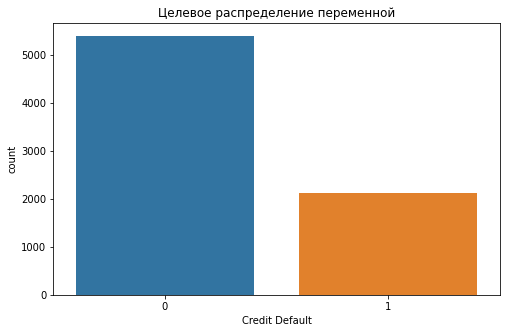

In [7]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Целевое распределение переменной')
plt.show()

In [45]:
df_train.head(6)

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0              7 years        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   
5           Rent      1168386.0              7 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   
5                     12.0                     14.6             366784.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  ...  \
0                        1.0                           0.0           1.0  ...   
1                        0.0                           0.0           0.0  ...   
2                        0.0                           0.0           0.0  ...   
3                        1.0                           0.0           1.0  ...   
4                        1.0                           0.0           0.0  ...   
5                        0.0                           0.0           0.0  ...   

         Term Current Loan Amount  Current Credit Balance  Monthly Debt  \
0  Short Term            309573.0                 47386.0        7914.0   
1   Long Term            264968.0                394972.0       18373.0   
2  Short Term            309573.0                308389.0       13651.0   
3  Short Term            121396.0                 95855.0       11338.0   
4  Short Term            125840.0                 93309.0        7180.0   
5   Long Term            337304.0                165680.0       18692.0   

   Credit Score  Credit Default  has_delay  unknown_income  \
0         749.0               0          1               0   
1         737.0               1          1               0   
2         742.0               0          1               0   
3         694.0               0          1               0   
4         719.0               0          1               0   
5         731.0               1          1               1   

   unknown_credit_score  term_binary  
0                     0            1  
1                     0            0  
2                     0            1  
3                     0            1  
4                     0            1  
5                     1            0  

[6 rows x 21 columns]

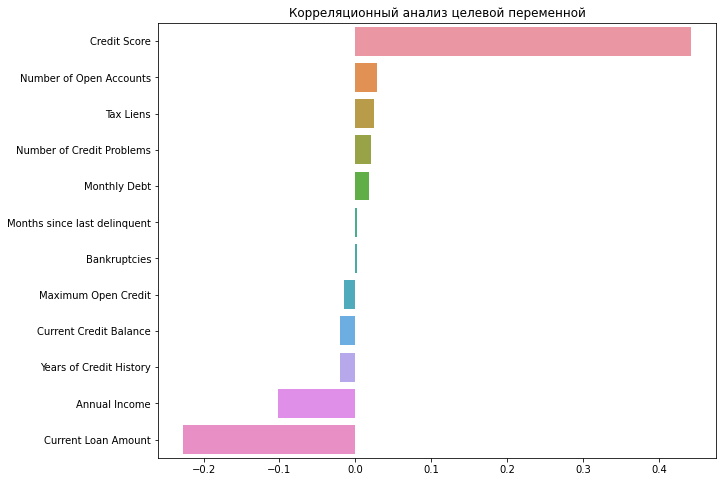

In [11]:
corr_with_target = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Корреляционный анализ целевой переменной')
plt.show()

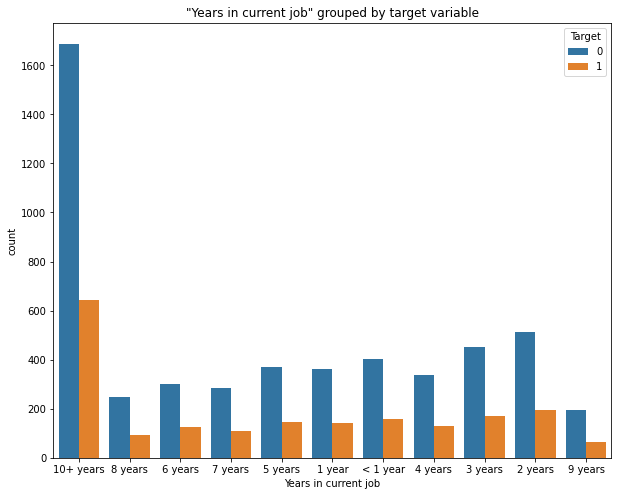

In [14]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Years in current job", hue=TARGET_NAME, data=df_train)
plt.title('\"Years in current job\" grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Отсутсвие значений в поле - "количество месяцев с последней просрочки платежа" связано с отсутсивием просрочки по платежам. в связи с чем значение NaN заменяется на значение "0". Новый признак (1- задолженность; 0-отсутствие задолженности)
Отсутствие значений в поле  - "годовой доход"  свидетельстьвуют о наличии незарегистрированного дохода.данные пропуски меняются на "медиану" и вводится новое значение 0 - незарегистрированный доход.
Имеются значение равные повторяющимся 9 - 999999999 в поле "текущая сумма кредита", что является некорректным и является "выбросом".

Коррекция выбросов и пропусков

In [15]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Новый критерий по задолженности (0- нет, 1- есть)

In [16]:
df_train['has_delay'] = 1
df_train.loc[(df_train['Months since last delinquent'] == 0), 'has_delay'] = 0

смена критерия NaN на значения 0

In [17]:
df_train['Months since last delinquent'].fillna(0, inplace=True)

статус дохода (0- незарегистрирован, 1- указан)

In [18]:
df_train['unknown_income'] = 0
df_train.loc[(df_train['Annual Income'].isnull()), 'unknown_income'] = 1

Водим переменную для медианного значения

In [19]:
annual_income_median = df_train['Annual Income'].median()
df_train['Annual Income'].fillna(annual_income_median, inplace=True)

In [44]:
df_train.isnull().sum()
df_train.head(6)

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0              7 years        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   
5           Rent      1168386.0              7 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   
5                     12.0                     14.6             366784.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  ...  \
0                        1.0                           0.0           1.0  ...   
1                        0.0                           0.0           0.0  ...   
2                        0.0                           0.0           0.0  ...   
3                        1.0                           0.0           1.0  ...   
4                        1.0                           0.0           0.0  ...   
5                        0.0                           0.0           0.0  ...   

         Term Current Loan Amount  Current Credit Balance  Monthly Debt  \
0  Short Term            309573.0                 47386.0        7914.0   
1   Long Term            264968.0                394972.0       18373.0   
2  Short Term            309573.0                308389.0       13651.0   
3  Short Term            121396.0                 95855.0       11338.0   
4  Short Term            125840.0                 93309.0        7180.0   
5   Long Term            337304.0                165680.0       18692.0   

   Credit Score  Credit Default  has_delay  unknown_income  \
0         749.0               0          1               0   
1         737.0               1          1               0   
2         742.0               0          1               0   
3         694.0               0          1               0   
4         719.0               0          1               0   
5         731.0               1          1               1   

   unknown_credit_score  term_binary  
0                     0            1  
1                     0            0  
2                     0            1  
3                     0            1  
4                     0            1  
5                     1            0  

[6 rows x 21 columns]

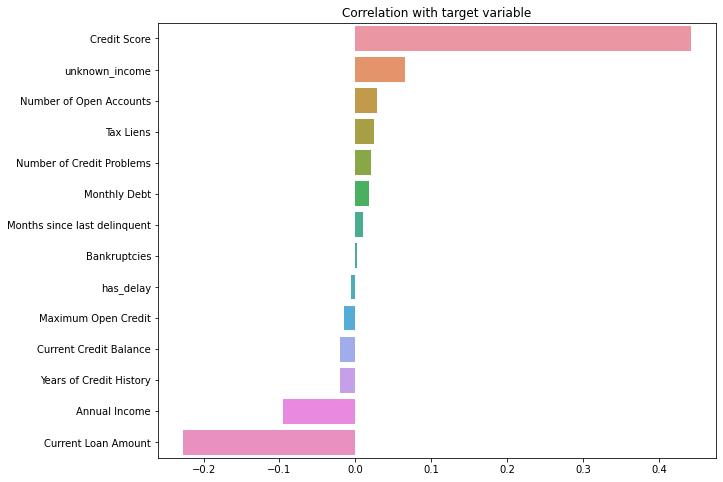

In [21]:
NEW_FEATURE_NAMES = ['has_delay','unknown_income']
corr_with_target = df_train[BASE_FEATURE_NAMES + 
                            NEW_FEATURE_NAMES + 
                            [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Анализ данных. Отбор признаков. Балансировка классов

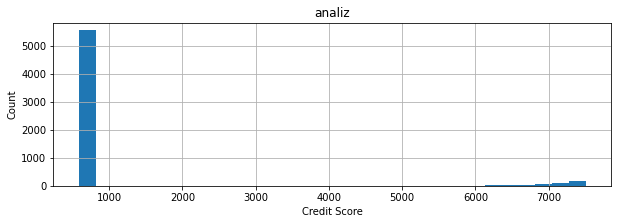

In [23]:
plt.figure(figsize = (10, 3))

df_train['Credit Score'].hist(bins=30, )
plt.ylabel('Count')
plt.xlabel('Credit Score')

plt.title('analiz')
plt.show()

In [27]:
df_train.isnull().sum()

Home Ownership                     0
Annual Income                      0
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
has_delay                          0
unknown_income                     0
dtype: int64

Коррекция "Credit Score"

In [28]:
df_train['unknown_credit_score'] = 0
NEW_FEATURE_NAMES = ['has_delay','unknown_income','unknown_credit_score']
credit_score_median = df_train['Credit Score'].median()
df_train.loc[(df_train['Credit Score'].isnull()), 'unknown_credit_score'] = 1
df_train['Credit Score'].fillna(credit_score_median, inplace=True)

Коррекция "Years in current job"

In [29]:
import random
unique_years_in_current_job = df_train['Years in current job'].unique()
var_experiance = unique_years_in_current_job[1:]
df_train['Years in current job'].fillna(random.choice(var_experiance), inplace=True)

In [30]:
df_train.isnull().sum()

Home Ownership                   0
Annual Income                    0
Years in current job             0
Tax Liens                        0
Number of Open Accounts          0
Years of Credit History          0
Maximum Open Credit              0
Number of Credit Problems        0
Months since last delinquent     0
Bankruptcies                    14
Purpose                          0
Term                             0
Current Loan Amount              0
Current Credit Balance           0
Monthly Debt                     0
Credit Score                     0
Credit Default                   0
has_delay                        0
unknown_income                   0
unknown_credit_score             0
dtype: int64

In [43]:
df_train.head(6)

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0              7 years        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   
5           Rent      1168386.0              7 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   
5                     12.0                     14.6             366784.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  ...  \
0                        1.0                           0.0           1.0  ...   
1                        0.0                           0.0           0.0  ...   
2                        0.0                           0.0           0.0  ...   
3                        1.0                           0.0           1.0  ...   
4                        1.0                           0.0           0.0  ...   
5                        0.0                           0.0           0.0  ...   

         Term Current Loan Amount  Current Credit Balance  Monthly Debt  \
0  Short Term            309573.0                 47386.0        7914.0   
1   Long Term            264968.0                394972.0       18373.0   
2  Short Term            309573.0                308389.0       13651.0   
3  Short Term            121396.0                 95855.0       11338.0   
4  Short Term            125840.0                 93309.0        7180.0   
5   Long Term            337304.0                165680.0       18692.0   

   Credit Score  Credit Default  has_delay  unknown_income  \
0         749.0               0          1               0   
1         737.0               1          1               0   
2         742.0               0          1               0   
3         694.0               0          1               0   
4         719.0               0          1               0   
5         731.0               1          1               1   

   unknown_credit_score  term_binary  
0                     0            1  
1                     0            0  
2                     0            1  
3                     0            1  
4                     0            1  
5                     1            0  

[6 rows x 21 columns]

Коррекция "Current Loan Amount"

In [32]:
median_current_loan_amount = df_train['Current Loan Amount'].median()
df_train.loc[(df_train['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = median_current_loan_amount

Коррекция "Bankruptcies"

In [34]:
df_train.Bankruptcies.value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [35]:
df_train['Bankruptcies'].fillna(0 , inplace=True)
df_train.Bankruptcies.value_counts()

0.0    6674
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [36]:
df_train.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
has_delay                       0
unknown_income                  0
unknown_credit_score            0
dtype: int64

In [37]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
7 years       767
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

Обработка "Term"

In [38]:
df_train['term_binary'] = df_train['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)
NEW_FEATURE_NAMES = ['has_delay','unknown_income','unknown_credit_score','term_binary']
df_train.select_dtypes(include='object').columns[1:]

Index(['Years in current job', 'Purpose', 'Term'], dtype='object')

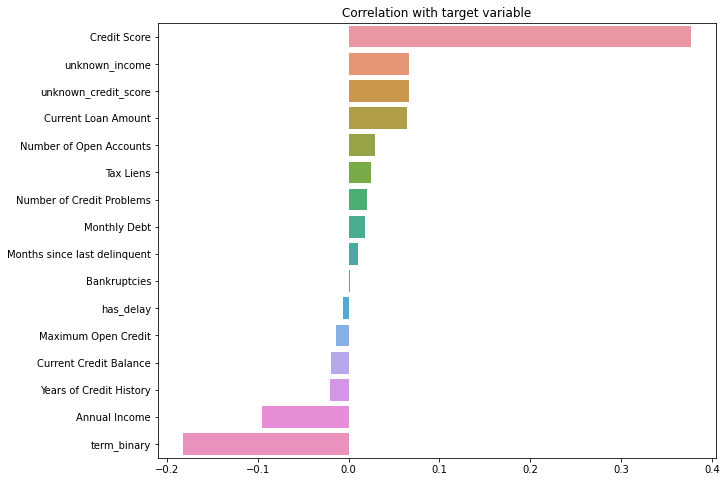

In [39]:
corr_with_target = df_train[BASE_FEATURE_NAMES + 
                            NEW_FEATURE_NAMES + 
                            [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [40]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

Выбираем модель, Baseline 

In [42]:
df_train.head(6)

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0              7 years        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   
5           Rent      1168386.0              7 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   
5                     12.0                     14.6             366784.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  ...  \
0                        1.0                           0.0           1.0  ...   
1                        0.0                           0.0           0.0  ...   
2                        0.0                           0.0           0.0  ...   
3                        1.0                           0.0           1.0  ...   
4                        1.0                           0.0           0.0  ...   
5                        0.0                           0.0           0.0  ...   

         Term Current Loan Amount  Current Credit Balance  Monthly Debt  \
0  Short Term            309573.0                 47386.0        7914.0   
1   Long Term            264968.0                394972.0       18373.0   
2  Short Term            309573.0                308389.0       13651.0   
3  Short Term            121396.0                 95855.0       11338.0   
4  Short Term            125840.0                 93309.0        7180.0   
5   Long Term            337304.0                165680.0       18692.0   

   Credit Score  Credit Default  has_delay  unknown_income  \
0         749.0               0          1               0   
1         737.0               1          1               0   
2         742.0               0          1               0   
3         694.0               0          1               0   
4         719.0               0          1               0   
5         731.0               1          1               1   

   unknown_credit_score  term_binary  
0                     0            1  
1                     0            0  
2                     0            1  
3                     0            1  
4                     0            1  
5                     1            0  

[6 rows x 21 columns]

In [46]:
NEW_FEATURE_NAMES

['has_delay', 'unknown_income', 'unknown_credit_score', 'term_binary']

In [47]:
SELECTED_FEATURE_NAMES = NUMB_FEATURE_NAMES + NEW_FEATURE_NAMES


X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=11)

In [48]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUMB_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMB_FEATURE_NAMES])

df_train = df_norm.copy()

In [49]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3768
1    2964
Name: Credit Default, dtype: int64

In [50]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

Регрессия

In [51]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.81      0.71      3768
           1       0.63      0.42      0.51      2964

    accuracy                           0.64      6732
   macro avg       0.64      0.61      0.61      6732
weighted avg       0.64      0.64      0.62      6732

TEST

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1619
           1       0.47      0.41      0.44       631

    accuracy                           0.71      2250
   macro avg       0.63      0.62      0.62      2250
weighted avg       0.69      0.71      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1328  291
1                372  259


k ближайших соседей

In [52]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      3768
           1       0.74      0.67      0.70      2964

    accuracy                           0.75      6732
   macro avg       0.75      0.74      0.74      6732
weighted avg       0.75      0.75      0.75      6732

TEST

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      1619
           1       0.35      0.39      0.37       631

    accuracy                           0.62      2250
   macro avg       0.55      0.55      0.55      2250
weighted avg       0.64      0.62      0.63      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1157  462
1                386  245


LightGBM

In [53]:
model_lgbm = lgbm.LGBMClassifier(random_state=11)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3768
           1       0.94      0.88      0.91      2964

    accuracy                           0.92      6732
   macro avg       0.92      0.92      0.92      6732
weighted avg       0.92      0.92      0.92      6732

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1619
           1       0.55      0.46      0.50       631

    accuracy                           0.74      2250
   macro avg       0.67      0.65      0.66      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1380  239
1                343  288


CatBoost

In [55]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=11)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      3768
           1       0.93      0.84      0.88      2964

    accuracy                           0.90      6732
   macro avg       0.90      0.89      0.90      6732
weighted avg       0.90      0.90      0.90      6732

TEST

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1619
           1       0.55      0.44      0.49       631

    accuracy                           0.74      2250
   macro avg       0.67      0.65      0.66      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1393  226
1                354  277


Выбираем модель и настраиваем гиперпараметров

In [60]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=11)

In [61]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [62]:
cv=KFold(n_splits=3, random_state=11, shuffle=True)

In [63]:
rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=11, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000023E415F7460>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [64]:
rs.best_params_

{'n_estimators': 100, 'max_depth': 7}

In [65]:
rs.best_score_

0.5394068539109662

Контроль качества и контроль переобучения

In [66]:
final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3,
                                      silent=True, random_state=11)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      3768
           1       0.80      0.62      0.70      2964

    accuracy                           0.76      6732
   macro avg       0.77      0.75      0.75      6732
weighted avg       0.77      0.76      0.76      6732

TEST

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1619
           1       0.55      0.48      0.51       631

    accuracy                           0.74      2250
   macro avg       0.68      0.66      0.67      2250
weighted avg       0.73      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1367  252
1                326  305


Подготовка выходного файла

In [67]:
df_test['has_delay'] = 1
df_test['Months since last delinquent'].fillna(0, inplace=True)
df_test.loc[(df_test['Months since last delinquent'] == 0), 'has_delay'] = 0
df_test['unknown_income'] = 0
annual_income_median = df_test['Annual Income'].median()
df_test.loc[(df_test['Annual Income'].isnull()), 'unknown_income'] = 1
df_test['Annual Income'].fillna(annual_income_median, inplace=True)
df_test['unknown_credit_score'] = 0
NEW_FEATURE_NAMES = ['has_delay','unknown_income','unknown_credit_score']
credit_score_median = df_test['Credit Score'].median()
df_test.loc[(df_test['Credit Score'].isnull()), 'unknown_credit_score'] = 1
df_test['Credit Score'].fillna(credit_score_median, inplace=True)
unique_years_in_current_job = df_test['Years in current job'].unique()
var_experiance = unique_years_in_current_job[1:]
df_test['Years in current job'].fillna(random.choice(var_experiance), inplace=True)
median_current_loan_amount = df_test['Current Loan Amount'].median()
df_test.loc[(df_test['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = median_current_loan_amount
df_test['term_binary'] = df_test['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

In [68]:
df_for_model = df_test[SELECTED_FEATURE_NAMES]
df_for_model.head(6)

Annual Income  Tax Liens  Number of Open Accounts  Years of Credit History  \
0      1178475.0        0.0                      9.0                     12.5   
1       231838.0        0.0                      6.0                     32.7   
2      1152540.0        0.0                     10.0                     13.7   
3      1220313.0        0.0                     16.0                     17.0   
4      2340952.0        0.0                     11.0                     23.6   
5       922583.0        0.0                     26.0                     17.5   

   Maximum Open Credit  Number of Credit Problems  \
0             220968.0                        0.0   
1              55946.0                        0.0   
2             204600.0                        0.0   
3             456302.0                        0.0   
4            1207272.0                        0.0   
5             713174.0                        0.0   

   Months since last delinquent  Bankruptcies  Current Loan Amount  \
0                          70.0           0.0             162470.0   
1                           8.0           0.0              78298.0   
2                           0.0           0.0             200178.0   
3                          70.0           0.0             217382.0   
4                           0.0           0.0             777634.0   
5                          41.0           0.0              94028.0   

   Current Credit Balance  Monthly Debt  Credit Score  has_delay  \
0                105906.0        6813.0         731.0          1   
1                 46037.0        2318.0         699.0          1   
2                146490.0       18729.0        7260.0          0   
3                213199.0       27559.0         739.0          1   
4                425391.0       42605.0         706.0          0   
5                135508.0       11148.0         679.0          1   

   unknown_income  unknown_credit_score  term_binary  
0               1                     1            1  
1               0                     0            1  
2               0                     0            1  
3               0                     0            1  
4               0                     0            0  
5               0                     0            1

In [69]:
y_pred_output = final_model.predict(df_for_model)
y_pred_output.shape

(2500,)

In [70]:
result=pd.DataFrame({'Id':np.arange(2500), 'Credit Default': y_pred_output})

In [71]:
RESULT_PATH='Desktop\TEST\EGoryachkin_predictions.csv'
result.to_csv(RESULT_PATH, index=False)

In [72]:
SAMPLE = 'Desktop\TEST\EGoryachkin_predictions.csv'
df_sample = pd.read_csv(SAMPLE)

predictions = pd.DataFrame(index = df_sample['Id'])

predictions[TARGET_NAME] = y_pred_output
predictions

Credit Default
Id                  
0                  0
1                  0
2                  1
3                  0
4                  0
...              ...
2495               0
2496               1
2497               0
2498               0
2499               1

[2500 rows x 1 columns]